# Clustering / segmentation des données Olist

Maintenant que notre analyse exploratoire est faite, nous allons nous intéresser à la segmentation des données de Olist.

Commençons par définir le nombre de clusters en implémentant la méthode Elbow mais tout d'abord, démarrons par importer nos librairies :

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

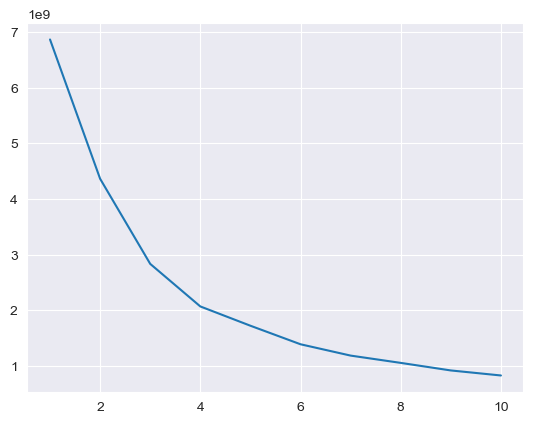

In [2]:
data = pd.read_csv("data/rfm_data.csv")

data_without_customer_id = pd.DataFrame({ "(days)last_purchase": data["(days)last_purchase"], "total_orders": data["total_orders"], "total_spend": data["total_spend"] })

wcss = []

for i in range(1, 11):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=42)
    clustering.fit(data_without_customer_id)
    wcss.append(clustering.inertia_)

ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sns.lineplot(x = ks, y = wcss);

D'après la méthode d'Elbow, le nombre idéal de cluster est à 4.

Implémentons notre K-Means :

In [3]:
from sklearn.preprocessing import StandardScaler


def kmean_process(data, cluster_n, random_state, asc=False):
    data_temp = data.copy()

    kmean_model = KMeans(n_clusters=cluster_n, random_state=random_state).fit(data_temp)
    group = data.assign(cluster=kmean_model.labels_)

    group_mean = group.groupby('cluster').mean().reset_index()
    group_mean = group_mean.sort_values(by=group_mean.columns[1],ascending=asc)
    group_mean['cluster_set'] = [i for i in range(cluster_n, 0, -1) ]
    cluster_map = group_mean.set_index('cluster').to_dict()['cluster_set']

    return group['cluster'].map(cluster_map)


r_labels = kmean_process(data[['(days)last_purchase']], cluster_n=6, random_state=1, asc=True)
f_labels = kmean_process(data[['total_orders']], cluster_n=6, random_state=1)
m_labels = kmean_process(data[['total_spend']], cluster_n=6, random_state=1)

final_csv = pd.DataFrame({ "(days)last_purchase": r_labels, 'total_orders': f_labels, 'total_spend': m_labels })
final_csv.to_csv('data/final_data.csv')

rfm_data = data.assign(R = r_labels, F = f_labels, M = m_labels)

rfm_data['R'] = rfm_data['R'] - 1
rfm_data['R'] = rfm_data['F'] - 1
rfm_data['R'] = rfm_data['M'] - 1

rfm_data.groupby('R')['(days)last_purchase'].describe()


,count,mean,std,min,25%,50%,75%,max
R,,,,,,,,
0,61100.0,241.009869,153.071742,0.0,117.00,223.0,351.00,695.0
1,27162.0,234.684412,151.362626,0.0,113.00,215.0,341.00,713.0
2,6179.0,239.853860,154.927031,0.0,115.00,218.0,345.00,694.0
3,1653.0,240.082880,156.168201,3.0,108.00,220.0,359.00,693.0
4,362.0,233.549724,161.251645,3.0,100.25,201.0,348.75,579.0
5,22.0,285.954545,213.290876,25.0,86.00,246.5,497.00,570.0


Nous voyons ici que la récurrence des commandes se situent entre 3 et 25 mois, ce qui semble assez significatif.

In [4]:
rfm_data.groupby('F')['total_orders'].describe()

,count,mean,std,min,25%,50%,75%,max
F,,,,,,,,
1,86843.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,7392.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
3,1306.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
4,688.0,4.280523,0.449582,4.0,4.0,4.0,5.0,5.0
5,224.0,6.209821,0.564806,6.0,6.0,6.0,6.0,9.0
6,25.0,12.640000,3.302524,10.0,10.0,12.0,14.0,21.0


Nous voyons ici que seulement 3% des consommateurs font plus d'une commande.

In [5]:
rfm_data.groupby('M')['total_spend'].describe()

,count,mean,std,min,25%,50%,75%,max
M,,,,,,,,
1,61100.0,74.511922,31.472319,9.59,47.9500,71.140,99.900,137.65
2,27162.0,200.850164,50.512692,137.66,159.6525,188.270,231.650,332.87
3,6179.0,465.103641,111.115056,332.89,370.7600,428.250,545.070,737.04
4,1653.0,1009.849080,216.565880,737.36,827.9100,942.780,1158.990,1544.62
5,362.0,2082.497431,445.541996,1549.41,1734.3500,1989.855,2249.905,3602.47
6,22.0,5208.325455,2221.678369,3666.42,4021.2925,4320.130,5798.740,13664.08


Ici nous pouvons voir qu'en moyenne les clients dépensent environ 74$.

Essayons de regrouper nos utilisateurs dans des groupes.

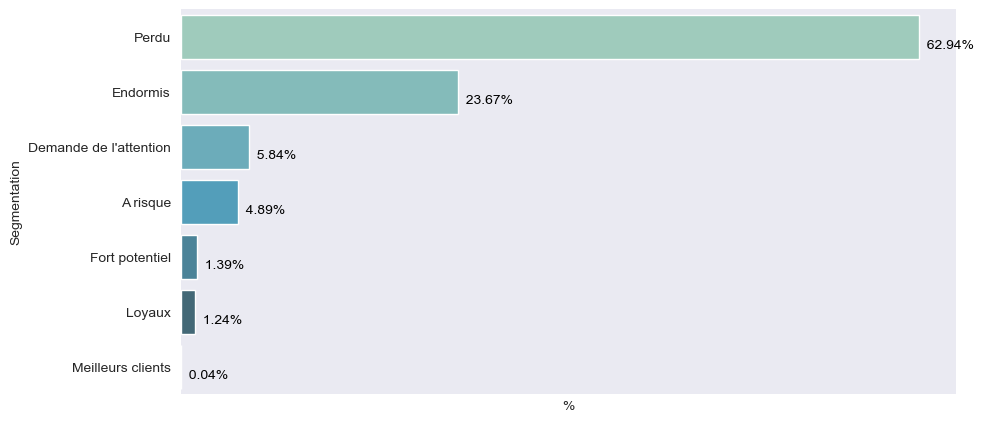

In [6]:
def segment(data):
    mean_fm = (data['F'] + data['M']) / 2

    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 4 and mean_fm <= 5):
        return 'Meilleurs clients'
    if (data['R'] >= 2 and data['R'] <= 5) and (mean_fm >= 3 and mean_fm <= 5):
        return 'Loyaux'
    if (data['R'] >= 3 and data['R'] <= 5) and (mean_fm >= 1 and mean_fm <= 3):
        return 'Fort potentiel'
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 0 and mean_fm <= 1):
        return 'Nouveau'
    if (data['R'] >= 3 and data['R'] <= 4) and (mean_fm >= 0 and mean_fm <= 1):
        return 'Prometteur'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 2 and mean_fm <= 3):
        return "Demande de l'attention"
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 0 and mean_fm <= 2):
        return 'Passif'
    if (data['R'] >= 0 and data['R'] <= 2) and (mean_fm >= 2 and mean_fm <= 5):
        return 'A risque'
    if (data['R'] >= 0 and data['R'] <= 1) and (mean_fm >= 4 and mean_fm <= 5):
        return "Bientôt Perdu"
    if (data['R'] >= 1 and data['R'] <= 2) and (mean_fm >= 1 and mean_fm <= 2):
        return 'Endormis'
    return 'Perdu'

rfm_data['segment'] = rfm_data.apply(segment, axis=1)

plt.figure(figsize=(10, 5))
percentage = (rfm_data['segment'].value_counts(normalize=True)* 100).reset_index(name='%')
g = sns.barplot(x=percentage['%'],y=percentage['index'], data=percentage,palette="GnBu_d")
sns.despine(bottom = True, left = True)
for i, v in enumerate(percentage['%']):
    g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
g.set_ylabel('Segmentation')
g.set(xticks=[])
plt.show()

# Conclusion
